In [2]:
import pandas as pd
import datasets
import matplotlib.pyplot as plt
import numpy as np
import os
os.makedirs("plots", exist_ok=True)
datasets.disable_progress_bar()

In [5]:
res_ds = datasets.load_from_disk("/home/gpucce/Repos/abstraction_ladders/acl_abstraction_ladders/abstraction_ladders_resources/src/primary_school/results/all_with_spec_results.ds")

In [16]:
res_ds = res_ds.map(lambda x: {
        "tp": len([i for i in x["clean_list"] if i in x["matches"]]),
        "tn": len([i for i in x["full_list"] if i not in x["clean_list"] and i not in x["matches"]]),
        "fp": len([i for i in x["full_list"] if i not in x["clean_list"] and i in x["matches"]]),
        "fn": len([i for i in x["clean_list"] if i not in x["matches"]]),
        "full_len": len(x["full_list"]),
        "clean_len": len(x["clean_list"])
})

In [22]:
print("n samples", sum(res_ds["full_len"]))
print('n samples v2', (sum(res_ds["tp"]) + sum(res_ds["tn"]) + sum(res_ds["fp"]) + sum(res_ds["fn"])))
print("negative", sum(res_ds["full_len"]) - sum(res_ds["clean_len"]))
print('positives', sum(res_ds["clean_len"]))
print("tp", sum(res_ds["tp"]))
print("tn", sum(res_ds["tn"]))
print("fp", sum(res_ds["fp"]))
print("fn", sum(res_ds["fn"]))

print("precision", sum(res_ds["tp"]) / (sum(res_ds["tp"]) + sum(res_ds["fp"])))
print("recall", sum(res_ds["tp"]) / (sum(res_ds["tp"]) + sum(res_ds["fn"])))
print("accuracy", (sum(res_ds["tp"]) + sum(res_ds["tn"])) / (sum(res_ds["tp"]) + sum(res_ds["tn"]) + sum(res_ds["fp"]) + sum(res_ds["fn"])))

n samples 5164
n samples v2 5164
negative 1698
positives 3466
tp 3314
tn 1448
fp 250
fn 152
precision 0.9298540965207632
recall 0.9561454125793422
accuracy 0.9221533694810224


In [2]:
words_df = pd.read_csv("./src/primary_school/results/primary_school_word_results.csv", index_col=0).map(eval)
stimuli_df = pd.read_excel("/home/gpucce/Repos/abstraction_ladders/acl_abstraction_ladders/abstraction_ladders_resources/src/primary_school/data_excluded_words.xlsx", sheet_name="Stimuli")
stimuli_df.loc[:, "word"] = stimuli_df.word.str.strip()
print(stimuli_df.semantic_type.unique())
stimuli_df_group = stimuli_df.groupby("semantic_type")

['concrete' 'abstract' 'emotions' 'social_role']


In [3]:
semantic_metrics_df = {semantic_type:pd.DataFrame() for semantic_type in stimuli_df.semantic_type.unique()}

for semantic_type, group in stimuli_df_group:
    new_row = {}
    for setting in words_df.index[:3]:
        for word in group.word:
            metrics = words_df.loc[setting, word]
            for m in ["n", "p", "tp", "tn", "fp", "fn", "total lists"]:
                new_row[m] = metrics[m] if m not in new_row else new_row[m] + metrics[m]
            new_row["correct_lists"] = metrics["list accuracy"] * metrics["total lists"] if "correct_lists" not in new_row else new_row["correct_lists"] + metrics["list accuracy"] * metrics["total lists"]

        new_row["accuracy"] = (new_row["tp"] + new_row["tn"]) / (new_row["tp"] + new_row["tn"] + new_row["fp"] + new_row["fn"])
        new_row["precision"] = new_row["tp"] / (new_row["tp"] + new_row["fp"]) if (new_row["tp"] + new_row["fp"]) > 0 else 0
        new_row["recall"] = new_row["tp"] / (new_row["tp"] + new_row["fn"]) if (new_row["tp"] + new_row["fn"]) > 0 else 0
        new_row["f1"] = 2 * (new_row["precision"] * new_row["recall"]) / (new_row["precision"] + new_row["recall"]) if (new_row["precision"] + new_row["recall"]) > 0 else 0
        new_row["list accuracy"] = new_row["correct_lists"] / new_row["total lists"]
        semantic_metrics_df[semantic_type][setting] = pd.Series(new_row)

semantic_metrics_df["social role"] = semantic_metrics_df["social_role"]
del semantic_metrics_df["social_role"]
for semantic_type in semantic_metrics_df:
    semantic_metrics_df[semantic_type] = semantic_metrics_df[semantic_type].T
    semantic_metrics_df[semantic_type]["type"] = semantic_type

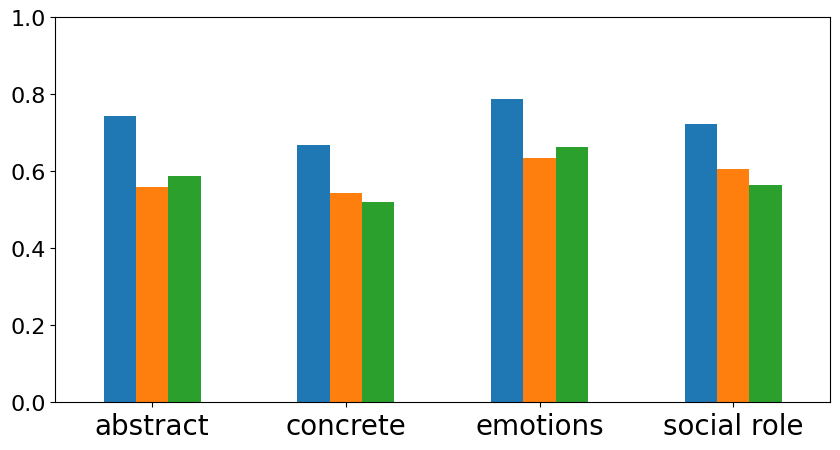

In [4]:
fig, ax = plt.subplots(figsize=(10,5))
df = pd.concat(semantic_metrics_df.values()).reset_index().pivot(index="type", columns="index", values="list accuracy").plot(kind="bar", ax=ax, legend=False) # .to_csv("plots/accuracy_by_semantic_type.csv")
ax.tick_params(axis='y', labelsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=20)
# ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
ax.set_ylim(0, 1)
ax.set_xlabel("")
words = "_".join(group.word)
fig.savefig(f"plots/acc_semantic_groups.png", dpi=300)


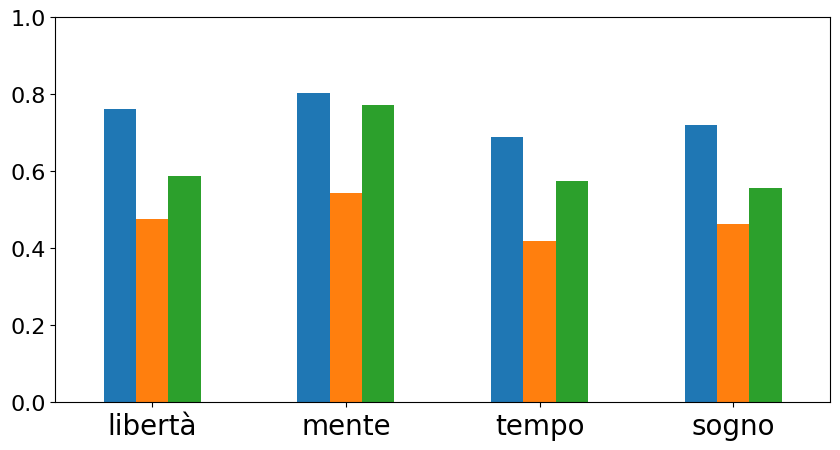

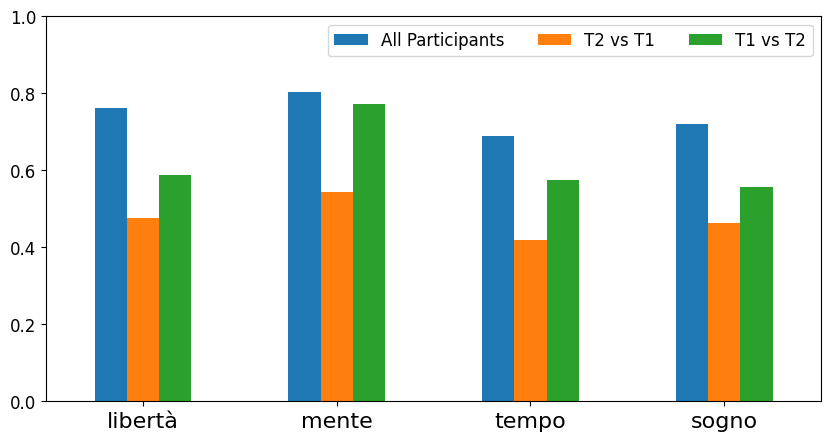

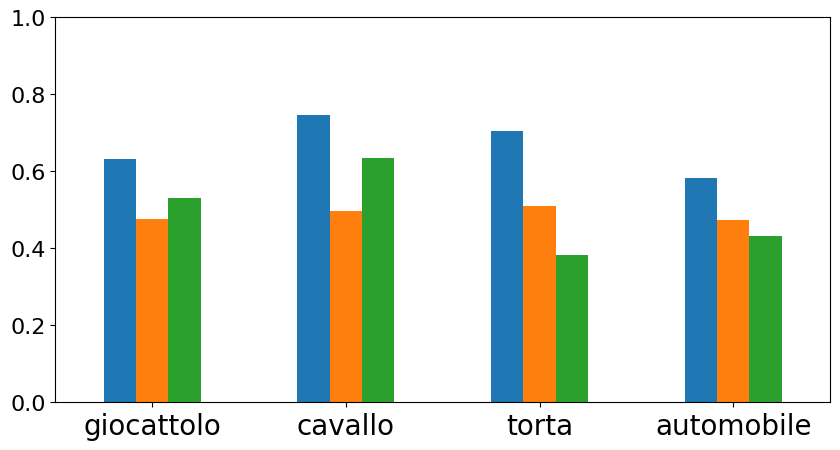

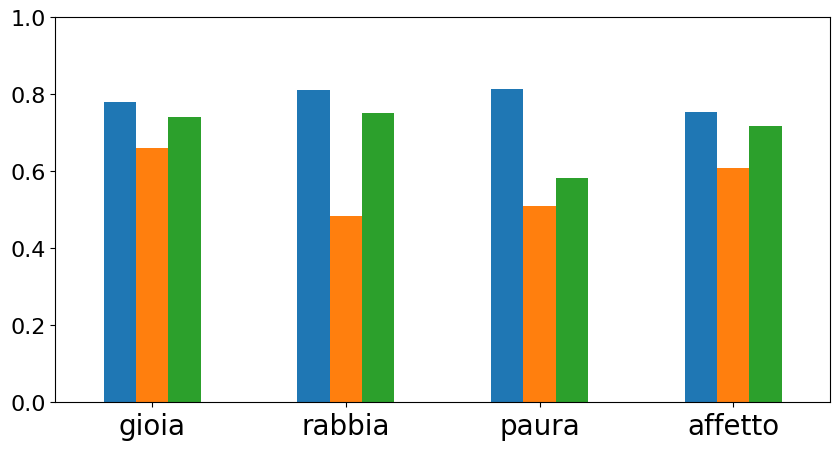

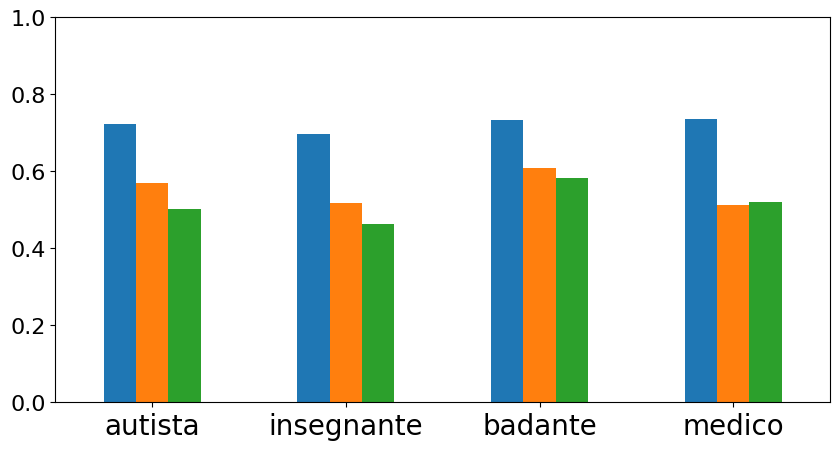

In [5]:
for idx, (semantic_type, group) in enumerate(stimuli_df_group):

    fig, ax = plt.subplots(figsize=(10,5))
    # ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=16)
    words_df.loc[["all_with_spec", "t1_vs_t2_with_spec", "t2_vs_t1_with_spec"], group.word].T.map(
        lambda x: x["list accuracy"]).plot(kind="bar", ax=ax, legend=False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=20)
    # ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    ax.set_ylim(0, 1)
    words = "_".join(group.word)
    fig.savefig(f"plots/acc_{words}.png", dpi=300)
    if idx == 0:
        fig, ax = plt.subplots(figsize=(10,5))
        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)
        words_df.loc[["all_with_spec", "t1_vs_t2_with_spec", "t2_vs_t1_with_spec"], group.word].T.map(
            lambda x: x["list accuracy"]).plot(kind="bar", ax=ax, legend=False)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=16)
        ax.set_ylim(0, 1)
        handles, labels = ax.get_legend_handles_labels()
        labels = ["All Participants", "T2 vs T1", "T1 vs T2"]
        legend = ax.legend(handles, labels, ncol=3, fontsize=12)

        # Save the legend as a separate file
        fig_legend = legend.figure
        fig_legend.canvas.draw()
        bbox = legend.get_window_extent().transformed(fig_legend.dpi_scale_trans.inverted())
        fig_legend.savefig("plots/words_acc_legend.png", bbox_inches=bbox)

# fig.legend(ncol=4, bbox_to_anchor=(1.0, 1.1))


In [6]:

base_df_t1 = pd.read_excel("/home/gpucce/Repos/abstraction_ladders/acl_abstraction_ladders/abstraction_ladders_resources/src/primary_school/data_excluded_words.xlsx", sheet_name="Time1")
base_df_t2 = pd.read_excel("/home/gpucce/Repos/abstraction_ladders/acl_abstraction_ladders/abstraction_ladders_resources/src/primary_school/data_excluded_words.xlsx", sheet_name="Time2")
base_df_t2.loc[base_df_t2["n_cohypernyms"] == " ", "n_cohypernyms"] = pd.NA
# base_df_t2.loc[:, "n_cohypernyms"] = pd.to_numeric(base_df_t2["n_cohypernyms"], errors="coerce")
base_df_t2["n_cohypernyms"] = base_df_t2["n_cohypernyms"].astype("Float64")

In [7]:
def add_infoes(ds):
    ds = ds.map(lambda x: {"word": x["word"].strip().lower()}, desc=None)
    ds = ds.map(lambda x: {"clean_len": len(x["clean_list"]), "full_len": len(x["full_list"])}, desc=None)
    ds = ds.map(lambda x: {"child_acc": x["clean_len"] / (x["clean_len"] + x["full_len"])}, desc=None) # ["full_len", "clean_len", "child_acc"]
    return ds

all_ds = datasets.load_from_disk("/home/gpucce/Repos/abstraction_ladders/acl_abstraction_ladders/abstraction_ladders_resources/src/primary_school/results/all_with_spec_results.ds")
all_t1 = datasets.load_from_disk("/home/gpucce/Repos/abstraction_ladders/acl_abstraction_ladders/abstraction_ladders_resources/src/primary_school/results/t2_vs_t1_with_spec_results.ds")
all_t1 = add_infoes(all_t1)

all_t2 = datasets.load_from_disk("/home/gpucce/Repos/abstraction_ladders/acl_abstraction_ladders/abstraction_ladders_resources/src/primary_school/results/t1_vs_t2_with_spec_results.ds")
all_t2 = add_infoes(all_t2)

words = set(all_t1["word"])
assert words == set(all_t2["word"])

stats_df = pd.concat(
    {"t1": all_t1.to_pandas()[["clean_len", "full_len", "child_acc"]].mean(), # ["full_len", "clean_len", "child_acc"]
     "t2": all_t2.to_pandas()[["clean_len", "full_len", "child_acc"]].mean()}, axis=1
).T

stats_df["n_lists"] = [len(all_t1), len(all_t2)]

words_stats_df = {}
for word in words:
    word_ds = pd.concat(
        {"t1": all_t1.filter(lambda x: x["word"] == word, desc=None).to_pandas()[["clean_len", "full_len", "child_acc"]].mean(), # ["full_len", "clean_len", "child_acc"]
         "t2": all_t2.filter(lambda x: x["word"] == word, desc=None).to_pandas()[["clean_len", "full_len", "child_acc"]].mean()}, axis=1
    ).T
    word_ds["word"] = word
    words_stats_df[word] = word_ds
words_stats_df = pd.concat(words_stats_df.values()).reset_index()
# t2_acc = words_stats_df[words_stats_df['index'] == 't2'][['word', 'child_acc']].set_index('word')

# # Map those t2 values back to all rows
# words_stats_df['t2_acc'] = words_stats_df['word'].map(t2_acc['child_acc'])

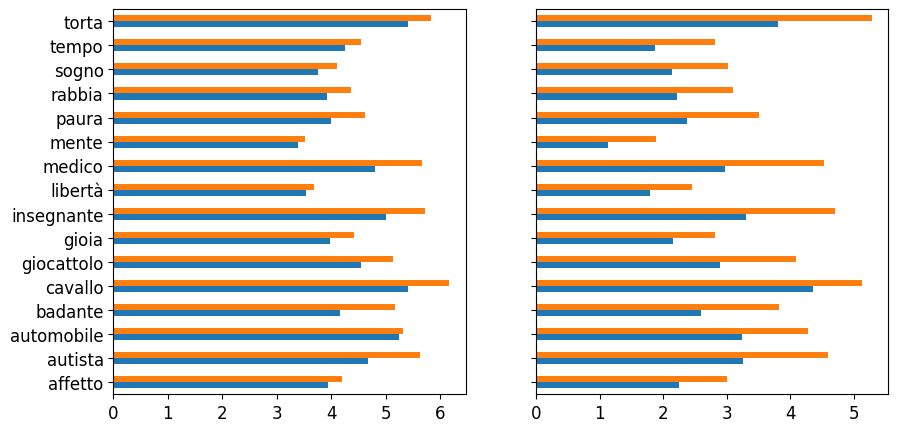

In [8]:
# pd.DataFrame.from_dict(words_stats_df)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

words_stats_df.reset_index().pivot(index="word", columns="index", values="full_len").plot(kind="barh", ax=ax[0], legend=False)
words_stats_df.reset_index().pivot(index="word", columns="index", values="clean_len").plot(kind="barh", ax=ax[1], legend=False)

ax[0].tick_params(axis='x', labelsize=12)
ax[1].tick_params(axis='x', labelsize=12)
ax[0].tick_params(axis='y', labelsize=12)
ax[1].tick_params(axis='y', labelsize=12)


ax[0].set_ylabel("")
ax[0].set_xlabel("")
ax[1].set_xlabel("")
ax[1].set_ylabel("")
ax[1].set_yticklabels("")
ax[0].legend().remove()
ax[1].legend().remove()
handles, labels = ax[0].get_legend_handles_labels()
# fig.legend(handles, labels, ncols=2)

fig.canvas.draw()
renderer = fig.canvas.get_renderer()

bbox = ax[0].get_tightbbox(renderer).transformed(fig.dpi_scale_trans.inverted())
fig.savefig("plots/full_list_length.png", bbox_inches=bbox)

bbox = ax[1].get_tightbbox(renderer).transformed(fig.dpi_scale_trans.inverted())
fig.savefig(f"plots/clean_list_length.png", bbox_inches=bbox)

fig_legend = plt.figure(figsize=(3, 1))
fig_legend.legend(handles, labels, loc='center', ncol=2)
fig_legend.savefig("plots/legend_t1_t2.png", bbox_inches='tight')
plt.close(fig_legend)

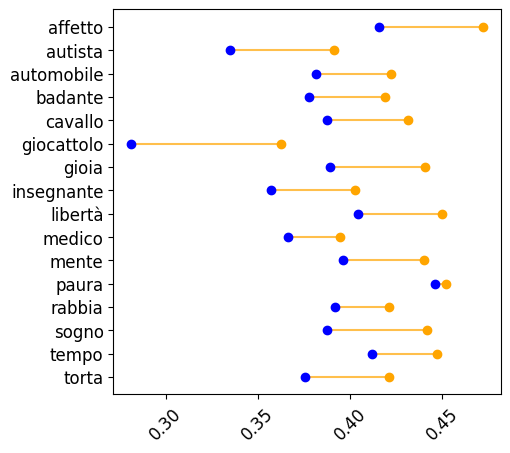

In [9]:
fig, ax = plt.subplots(figsize=(5, 5))
df2plot = words_stats_df.reset_index().pivot(index="word", columns="index", values="child_acc").reset_index()
n_rows = df2plot.shape[0]
df2plot = df2plot.iloc[::-1, :]  # Reverse the order of rows

# for _, row in df2plot.iterrows():
#     # ax.plot(['t1', 't2'], [row['t1'], row['t2']], marker='o', color='gray', alpha=0.7)
#     # ax.text('t2', row['t2'], row['word'], fontsize=8, va='center', ha='left')
#     ax.plot([row['t1'], row['t2']], [row['word'], row['word']], color='orange', alpha=0.7, zorder=1)
#     ax.scatter(row['t1'], row['word'], color='blue', label='t1' if _ == 0 else "")
#     ax.scatter(row['t2'], row['word'], color='orange', label='t2' if _ == 0 else "")

k = 1
ypos = np.arange(len(df2plot)) * k

for i, row in df2plot.iterrows():
    y = ypos[i]
    ax.plot([row['t1'], row['t2']], [y, y], color='orange', alpha=0.7, zorder=1)
    ax.scatter(row['t1'], y, color='blue', label='t1' if i == 0 else "", zorder=2)
    ax.scatter(row['t2'], y, color='orange', label='t2' if i == 0 else "", zorder=2)

ax.set_yticks(ypos)
ax.set_yticklabels(df2plot['word'])
ax.tick_params(axis='x', rotation=45, labelsize=12)
ax.tick_params(axis='y', labelsize=12)


ax.tick_params(axis='x', rotation=45, labelsize=12)
ax.tick_params(axis='y', labelsize=12)
fig.savefig("plots/acc_delta_among_times.png", bbox_inches='tight')

In [13]:
stats1 = base_df_t1[["n_free_association", "n_cohypernyms", "n_cohyponyms"]].describe().copy().loc[["count", "mean", "std"]]
stats1.loc["ratio", :] = stats1.loc["count", :] / base_df_t1.shape[0]
# stats1 = stats1.rename({"count": "Ratio"}, axis=0)
stats2 = base_df_t2[["n_free_association", "n_cohypernyms", "n_cohyponyms"]].describe().copy().loc[["count", "mean", "std"]]
stats2.loc["ratio", :] = stats2.loc["count", :] / base_df_t2.shape[0]
# stats2 = stats2.rename({"count": "Ratio"}, axis=0)

stats1.loc[:, "Time"] = "t1"
stats2.loc[:, "Time"] = "t2"

stats = pd.concat([stats1, stats2], axis=0).reset_index().rename({"index":"Stats"}, axis=1).set_index(["Time", "Stats"])
stats = stats.rename(columns={"n_free_association": "Free Associations", "n_cohyponyms": "Cohyponyms", "n_cohypernyms": "Cohypernyms"})
with open("tables/error_type_stats.tex", "w") as f:
    f.write(
        stats.to_latex(column_format="llccc", formatters={col: lambda x: f"{x:.3g}" if x < 10 else int(x) for col in stats.select_dtypes('number')}).replace("cline", "cmidrule")
    )
stats

Free Associations  Cohypernyms  Cohyponyms
Time Stats                                            
t1   count        1554.000000        655.0  671.000000
     mean            2.039254     1.187786    1.712370
     std             1.358147     0.488245    1.157382
     ratio           0.501129     0.211222    0.216382
t2   count        1056.000000        553.0  296.000000
     mean            1.648674     1.233273    1.557432
     std             1.014893     0.612236    1.049655
     ratio           0.431725     0.226083    0.121014

In [11]:
ds = datasets.load_from_disk("src/primary_school/results/all_without_spec_results.ds")
ds_t1_vs_t2 = datasets.load_from_disk("src/primary_school/results/t1_vs_t2_without_spec_results.ds").to_pandas().set_index("id")
ds_t2_vs_t1 = datasets.load_from_disk("src/primary_school/results/t2_vs_t1_without_spec_results.ds").to_pandas().set_index("id")
ds_pd = ds.to_pandas().set_index("id")
df_t1 = pd.read_excel("src/primary_school/data_excluded_words.xlsx", sheet_name="Time1")
df_t1["cohypernyms"] = df_t1["cohypernyms"].replace({" ": pd.NA})
df_t1["n_cohyperyms"] = df_t1["n_cohypernyms"].replace({" ": pd.NA})
df_t1.loc[:, "id"] = df_t1.index.astype(str) + "_" + df_t1["participants"]
df_t1 = df_t1.set_index('id')
df_t2 = pd.read_excel("src/primary_school/data_excluded_words.xlsx", sheet_name="Time2")
df_t2["cohypernyms"] = df_t2["cohypernyms"].replace({" ": pd.NA})
df_t2["n_cohypernyms"] = df_t2["n_cohypernyms"].replace({" ": pd.NA})
df_t2.loc[:, "id"] = df_t2.index.astype(str) + "_" + df_t2["participants"]
df_t2 = df_t2.set_index('id')
df = pd.concat([df_t1, df_t2])

joined_ds = ds_pd.join(df, rsuffix="original")
joined_ds["cohypernyms"] = joined_ds["cohypernyms"].replace(1, pd.NA)
joined_t2 = ds_t1_vs_t2.join(df_t2, rsuffix="original")
joined_t1 = ds_t2_vs_t1.join(df_t1, rsuffix='original')
experiments = {
    "all": joined_ds,
    "T1 vs T2": joined_t2,
    "T2 vs T1": joined_t1
}


def check_matches(x, col_name):
    col = [i.strip() for i in x[col_name].split(",")]
    out = {
        "found": len([i for i in col if i in [j.strip() for j in x["non_matches"]]]),
        "missed": len([i for i in col if i in [j.strip() for j in x["matches"]]]),
    }
    out["n_wrong"] = out["found"] + out["missed"]
    return out

future_stacked_df = []
for experiment, local_ds in experiments.items():
    future_df = {}
    for col_name in ["free_association", "cohyponyms", "cohypernyms",]:
        col_ds = datasets.Dataset.from_pandas(
            local_ds.loc[local_ds.loc[:, col_name].notna() & local_ds.loc[:, f"n_{col_name}"].notna(),  # remove broken rows
            [col_name, "non_matches", "matches", f"n_{col_name}", "words_excluded", "full_list"]]
        )
        col_ds = col_ds.map(lambda x: check_matches(x, col_name))
        future_df[col_name] = {}
        future_df[col_name]["N. Lists"] = len(col_ds)
        future_df[col_name]["N. Errors"] = int(sum(col_ds["n_wrong"]))
        future_df[col_name]["Found (\%)"] = str(sum(col_ds["found"])) + " " + f"({str(round(sum(col_ds['found']) / future_df[col_name]['N. Errors'], 2))})" # .replace("(0.", "(")
        future_df[col_name]["Missed (\%)"] = str(sum(col_ds["missed"])) + " " + f"({str(round(sum(col_ds['missed']) / future_df[col_name]['N. Errors'], 2))})" # .replace("(0.", "(")

        # future_df[col_name]["removed words"] = sum([len(i) for i in col_ds["non_matches"]])
        # future_df[col_name]["matched errors"] = sum(col_ds[f"{col_name}_non_matches"])

        # future_df[col_name]["true errors ratio"] = future_df[col_name]["n errors"] / future_df[col_name]["removed words"]
        # future_df[col_name]["found errors ratio"] = future_df[col_name]["matched errors"] / future_df[col_name]["n errors"]

    future_df = pd.DataFrame.from_dict(future_df, orient="index")
    future_df.loc[:, "experiment"] = experiment
    future_stacked_df.append(future_df)
error_type_df = pd.concat(future_stacked_df, axis=0)
error_type_df = error_type_df.rename({"free_association": "Free Associatoin", "cohyponyms": "Cohyponyms", "cohypernyms": "Cohypernyms"}, axis=0)
error_type_df = error_type_df.reset_index().set_index(["experiment", "index"])
with open("tables/error_type_comparison.tex", "w") as f:
    f.write(
        # stats.round(3).to_latex(flost_format="%.3g")
        error_type_df.to_latex(column_format="llcccccc", formatters={col: lambda x: f"{x:.3g}" if x < 1 else x for col in error_type_df.select_dtypes('number')}).replace("cline", "cmidrule")
    )
error_type_df

N. Lists  N. Errors   Found (\%) Missed (\%)
experiment index                                                         
all        Free Associatoin       540        998   848 (0.85)  150 (0.15)
           Cohyponyms             193        342   279 (0.82)   63 (0.18)
           Cohypernyms            231        280   244 (0.87)   36 (0.13)
T1 vs T2   Free Associatoin      1056       1739  1354 (0.78)  385 (0.22)
           Cohyponyms             296        459   348 (0.76)  111 (0.24)
           Cohypernyms            553        680   558 (0.82)  122 (0.18)
T2 vs T1   Free Associatoin      1554       3140  2429 (0.77)  711 (0.23)
           Cohyponyms             671       1143   621 (0.54)  522 (0.46)
           Cohypernyms            654        775   586 (0.76)  189 (0.24)

In [12]:
joined_t1["free_association"][joined_t1["free_association"].notna()].str.split(",").apply(len).sum(), joined_t2["free_association"][joined_t2["free_association"].notna()].str.split(",").apply(len).sum()

(np.int64(3178), np.int64(1746))